# 4. Decision Tree Regression

**KI1-Projekt 308** — California Housing Datensatz

**Schwerpunkt P2:** Regression Trees mit Pruning, Feature Importance,
Hyperparameter-Tuning (max_depth, ccp_alpha).

Vorlage: Blatt 08 (Decision Trees), Kapitel 4+6 Folien

In [8]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score

from utils.data import load_and_clean_data, get_train_test_split
from utils.evaluation import evaluate_model, add_result
from utils.plotting import (
    plot_predicted_vs_actual, plot_residuals,
    plot_feature_importances, save_fig,
)

plt.rcParams['figure.dpi'] = 100
%matplotlib inline

## 4.1 Daten laden

In [9]:
df = load_and_clean_data()
X_train, X_test, y_train, y_test, feature_names = get_train_test_split(df)

## 4.2 Decision Tree ohne Einschränkung (Overfitting-Referenz)

In [10]:
dt_full = DecisionTreeRegressor(random_state=42)
dt_full.fit(X_train, y_train)

result_full = evaluate_model(dt_full, X_train, X_test, y_train, y_test, "Decision Tree (unbeschränkt)")
add_result(result_full)
print(f"\nBaumtiefe: {dt_full.get_depth()}, Blätter: {dt_full.get_n_leaves()}")


  Decision Tree (unbeschränkt)
  R² Score:  Train = 1.0000  |  Test = 0.5538
  MAE:       Train = 0.0000  |  Test = 0.4114
  RMSE:      Train = 0.0000  |  Test = 0.6368

Baumtiefe: 36, Blätter: 13771


## 4.3 Hyperparameter-Tuning: max_depth

Gespeichert: results/dt_depth_tuning.png und results/dt_depth_tuning.pdf


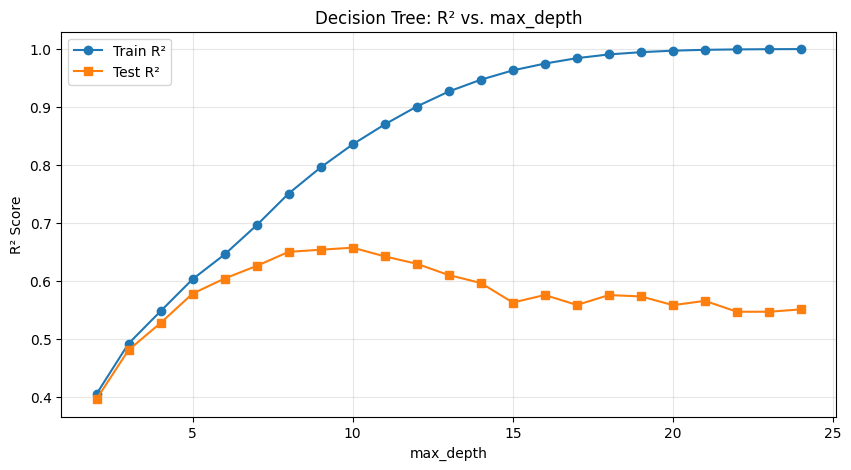

Beste max_depth: 10 (Test R² = 0.6572)


In [11]:
depths = range(2, 25)
train_scores = []
test_scores = []

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(depths), train_scores, 'o-', label='Train R²')
ax.plot(list(depths), test_scores, 's-', label='Test R²')
ax.set_xlabel('max_depth')
ax.set_ylabel('R² Score')
ax.set_title('Decision Tree: R² vs. max_depth')
ax.legend()
ax.grid(True, alpha=0.3)
save_fig(fig, 'dt_depth_tuning')
plt.show()

best_depth = list(depths)[np.argmax(test_scores)]
print(f"Beste max_depth: {best_depth} (Test R² = {max(test_scores):.4f})")

## 4.4 Pruning via Cost-Complexity (ccp_alpha)

Gespeichert: results/dt_pruning.png und results/dt_pruning.pdf


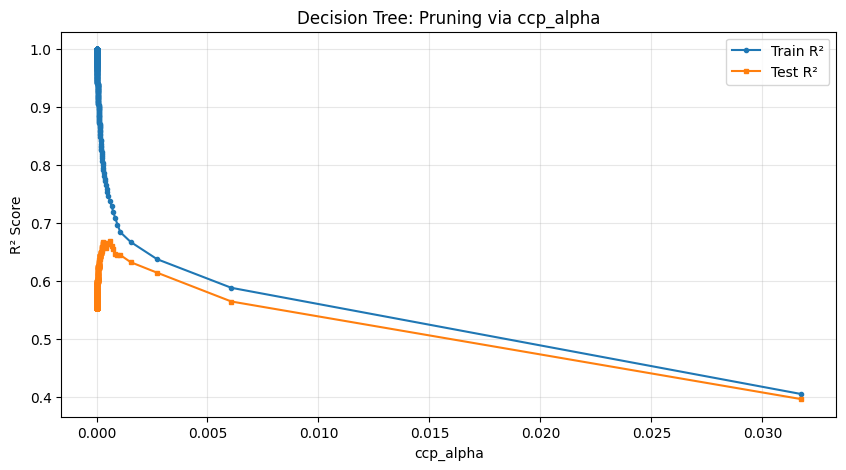

Bestes ccp_alpha: 0.000601 (Test R² = 0.6686)


In [12]:
# Cost-Complexity Pruning Path
dt_path = DecisionTreeRegressor(random_state=42)
dt_path.fit(X_train, y_train)
path = dt_path.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[::10]  # Jedes 10. Alpha für Effizienz

train_scores_ccp = []
test_scores_ccp = []

for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(ccp_alpha=alpha, random_state=42)
    dt.fit(X_train, y_train)
    train_scores_ccp.append(dt.score(X_train, y_train))
    test_scores_ccp.append(dt.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas, train_scores_ccp, 'o-', label='Train R²', markersize=3)
ax.plot(ccp_alphas, test_scores_ccp, 's-', label='Test R²', markersize=3)
ax.set_xlabel('ccp_alpha')
ax.set_ylabel('R² Score')
ax.set_title('Decision Tree: Pruning via ccp_alpha')
ax.legend()
ax.grid(True, alpha=0.3)
save_fig(fig, 'dt_pruning')
plt.show()

best_alpha = ccp_alphas[np.argmax(test_scores_ccp)]
print(f"Bestes ccp_alpha: {best_alpha:.6f} (Test R² = {max(test_scores_ccp):.4f})")

## 4.5 Bestes Modell trainieren und evaluieren

In [13]:
dt_best = DecisionTreeRegressor(max_depth=best_depth, ccp_alpha=best_alpha, random_state=42)
dt_best.fit(X_train, y_train)

result_best = evaluate_model(dt_best, X_train, X_test, y_train, y_test, f"Decision Tree (depth={best_depth})")
add_result(result_best)

print(f"\nBaumtiefe: {dt_best.get_depth()}, Blätter: {dt_best.get_n_leaves()}")


  Decision Tree (depth=10)
  R² Score:  Train = 0.7385  |  Test = 0.6691
  MAE:       Train = 0.3506  |  Test = 0.3861
  RMSE:      Train = 0.4911  |  Test = 0.5484

Baumtiefe: 10, Blätter: 118


Gespeichert: results/dt_feature_importances.png und results/dt_feature_importances.pdf


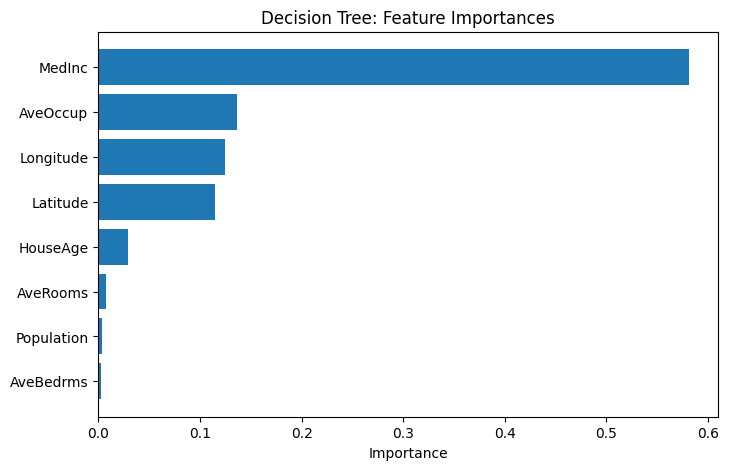

In [14]:
# Feature Importance
fig, ax = plot_feature_importances(
    dt_best.feature_importances_, feature_names,
    title="Decision Tree: Feature Importances",
    save_name="dt_feature_importances"
)
plt.show()

Gespeichert: results/dt_pred_vs_actual.png und results/dt_pred_vs_actual.pdf


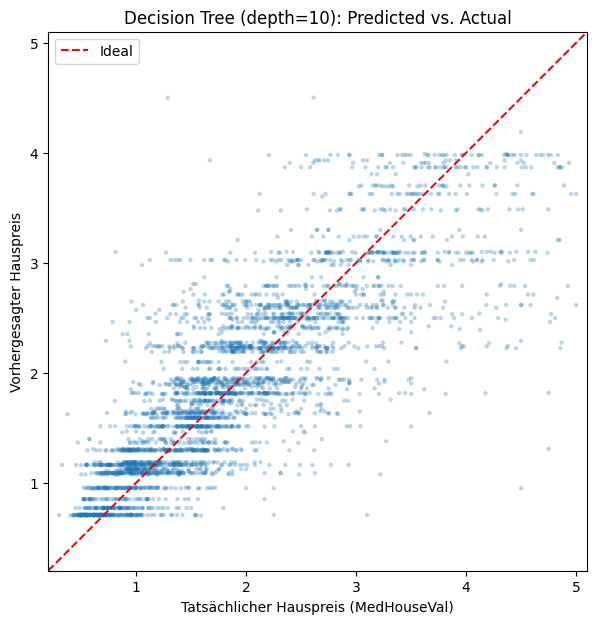

In [15]:
fig, ax = plot_predicted_vs_actual(
    y_test, dt_best.predict(X_test),
    title=f"Decision Tree (depth={best_depth}): Predicted vs. Actual",
    save_name="dt_pred_vs_actual"
)
plt.show()

## 4.6 Zusammenfassung

| Erkenntnis | Detail |
|-----------|--------|
| Unbeschränkter Baum | Perfekter Train-Score, aber starkes Overfitting |
| max_depth Tuning | Bias-Varianz-Tradeoff sichtbar |
| Pruning (ccp_alpha) | Reduziert Overfitting systematisch |
| Feature Importance | MedInc dominiert, ähnlich zur LASSO-Selektion |